In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import joblib


In [2]:
# Load Model + Feature List
model = joblib.load("../models/xgb_demand_model.pkl")
features = joblib.load("../models/feature_list.pkl")

In [3]:
# Load Data
df = pd.read_csv("../data/processed/processed_data.csv", parse_dates=["Date"])
df.head()

,Product_ID,Date,Base_Cost,Price,Competitor_Price,Inventory,Units_Demanded,Competitor_Delta,Margin,Price_Cost_Ratio,Inventory_Pressure,Day_Week,Month,Week_Year,rolling_demand_7,rolling_demand_30,lag_1,lag_7,lag_30
0,P1,2024-01-01,15.48,28.13,29.41,46,106,1.28,12.65,1.817183,0,0,1,1,106.000000,106.000000,0.0,0.0,0.0
1,P1,2024-01-02,15.48,28.94,28.40,156,78,-0.54,13.46,1.869509,0,1,1,1,92.000000,92.000000,106.0,0.0,0.0
2,P1,2024-01-03,15.48,27.54,27.36,178,112,-0.18,12.06,1.779070,0,2,1,1,98.666667,98.666667,78.0,0.0,0.0
3,P1,2024-01-04,15.48,28.00,30.52,143,114,2.52,12.52,1.808786,0,3,1,1,102.500000,102.500000,112.0,0.0,0.0
4,P1,2024-01-05,15.48,27.57,28.48,98,122,0.91,12.09,1.781008,0,4,1,1,106.400000,106.400000,114.0,0.0,0.0


In [ ]:
# Function to simulate demand at different price points
''' 
Takes the latest record
Modeifies the price
Predicts the expected units sold
Computes revenue and profit
'''
def simulate_prices(product_id, price_range):

    # Get the latest row for the product

    latest = df[df['Product_ID'] == product_id].sort_values('Date').iloc[-1]

    results = []

    for price in price_range:

        row = latest.copy()
        row['Price'] = price

        #Update features that depend on price

        row['Margin'] = row['Price'] - row['Base_Cost']
        row['Price_Cost_Ratio'] = row['Price'] / row['Base_Cost']
        row['Competitor_Delta'] = row['Competitor_Price'] - row['Price']

        #Convert to Dataframe for prediction

        X = pd.DataFrame([row[features]])
        demand = model.predict(X)[0]
        demand = max(demand, 0)  # Ensure non-negative demand

        revenue = demand * price
        profit = demand * (price - row['Base_Cost'])

        results.append([price,demand, revenue, profit])

    return pd.DataFrame(results, columns=['Price', 'Predicted_Demand', 'Revenue', 'Profit'])


In [10]:
# Optimization choose best price

''' To maximize revenue '''

def optimal_price_revenue(product_id, price_range):
    sims = simulate_prices(product_id, price_range)
    return sims.loc[sims['Revenue'].idxmax(), ['Price', 'Predicted_Demand', 'Revenue']]

In [11]:
''' To maximize profit '''

def optimal_price_profit(product_id, price_range):
    sims = simulate_prices(product_id, price_range)
    return sims.loc[sims['Profit'].idxmax(), ['Price', 'Predicted_Demand', 'Profit']]

In [12]:
# Trying It On A Product

product = "P10"

''' Get latest record for the product '''
latest = df[df['Product_ID'] == product].sort_values('Date').iloc[-1]

''' generating range of posiible prices from base cost to 2.5 times the base cost '''

price_range = np.linspace(latest['Base_Cost'], latest['Base_Cost'] * 2.5, 40 ) #40 candidate prices

In [13]:
opt_rev = optimal_price_revenue(product, price_range)
opt_prof = optimal_price_profit(product, price_range)

In [15]:
opt_rev

Price                 13.553846
Predicted_Demand      83.293098
Revenue             1128.941842
Name: 14, dtype: float64

In [16]:
opt_prof

Price                13.892692
Predicted_Demand     78.640823
Profit              399.707108
Name: 15, dtype: float64

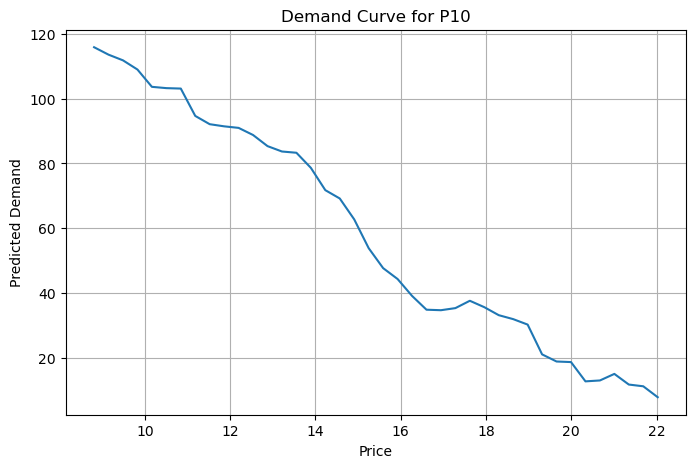

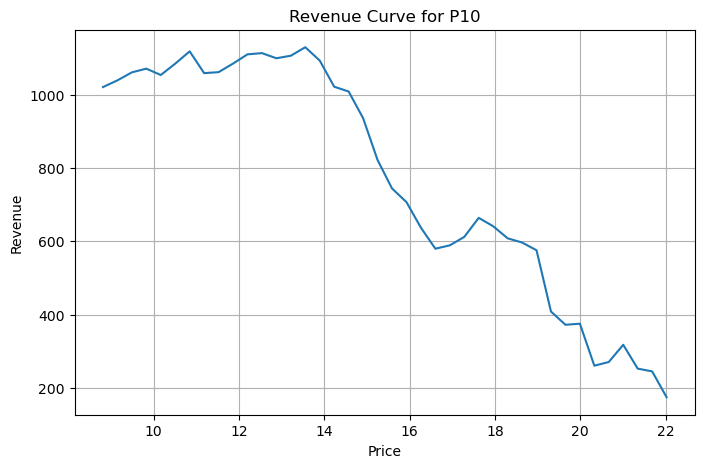

In [18]:
# Plotting Demand Curve
import matplotlib.pyplot as plt


sims = simulate_prices(product, price_range)

plt.figure(figsize=(8,5))

plt.plot(sims["Price"], sims["Predicted_Demand"])
plt.xlabel("Price")
plt.ylabel("Predicted Demand")
plt.title(f"Demand Curve for {product}")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(sims["Price"], sims["Revenue"])
plt.xlabel("Price")
plt.ylabel("Revenue")
plt.title(f"Revenue Curve for {product}")
plt.grid(True)
plt.show()

In [19]:
#EOF